In [67]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
from childes_mi.utils.paths import DATA_DIR, FIGURE_DIR
from childes_mi.utils.general import flatten,save_fig

In [17]:
from childes_mi.information_theory import model_fitting as mf

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

In [19]:
MI_DF = pd.read_pickle(DATA_DIR/'mi/epic_kitchens.pickle')

In [20]:
MI_DF[:3]

,MI,MI_var,shuff_MI,shuff_MI_var,distances
0,"[10.15572628962066, 10.019879244923246, 9.9284...","[0.013130092979006703, 0.013108715406449277, 0...","[9.86306100506604, 9.845054464535409, 9.821878...","[0.012926961391505462, 0.012997125608050908, 0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."


In [21]:
MI_DF = MI_DF.assign(**{i:np.nan for i in ['exp_results', 'pow_results', 'concat_results',
     'R2_exp', 'R2_concat', 'R2_power', 'AICc_exp',
     'AICc_concat', 'AICc_power', 'bestfitmodel', 'curvature', 'min_peak']})
MI_DF['curvature'] = MI_DF['curvature'].astype(object)

In [22]:
n = 100 # max distance for computation
for idx, row in tqdm(MI_DF.iterrows(), total=len(MI_DF)):
    # get signal
    sig = np.array(row.MI-row.shuff_MI)
    distances = row.distances
    sig = sig
    
    # fit models
    results_power, results_exp, results_pow_exp, best_fit_model = mf.fit_models(distances, sig)
    
    # get fit results
    R2_exp, R2_concat, R2_power, AICc_exp, \
        AICc_pow, AICc_concat = mf.fit_results(sig, distances, 
                                              results_exp, results_power,
                                              results_pow_exp)
    
    
    
    
    # get model y
    distances_mod = np.logspace(0,np.log10(n), base=10, num=1000)
    if best_fit_model == 'pow_exp':
        y_model = mf.get_y(mf.pow_exp_decay, results_pow_exp, distances_mod)
    elif best_fit_model == 'exp':
        y_model = mf.get_y(mf.exp_decay, results_exp, distances_mod)
    elif best_fit_model == 'pow':
        y_model = mf.get_y(mf.powerlaw_decay, results_power, distances_mod)
    
    # get curvature of model_y
    curvature_model = mf.curvature(np.log(y_model))
    
    # if the best fit model is pow_exp, then grab the min peak
    if best_fit_model == 'pow_exp':
        # get peaks of curvature
        peaks = np.where((
            (curvature_model[:-1] < curvature_model[1:])[1:] & (curvature_model[1:] < curvature_model[:-1])[:-1]
        ))
        min_peak = peaks[0][0]
    else:
        min_peak = np.nan

    # get save model fit results to MI_DF
    MI_DF.loc[idx, np.array(['exp_results', 'pow_results', 'concat_results',
                         'R2_exp', 'R2_concat', 'R2_power', 'AICc_exp',
                         'AICc_concat', 'AICc_power', 'bestfitmodel', 'curvature', 'min_peak'])] = [
        results_exp, results_power, results_pow_exp,
        R2_exp, R2_concat, R2_power, AICc_exp,
        AICc_concat, AICc_pow, best_fit_model,
        curvature_model, min_peak
    ]


/mnt/cube/tsainbur/Projects/github_repos/childes_mi_project/childes_mi/information_theory/model_fitting.py:8: RuntimeWarning: invalid value encountered in log
  return np.abs(np.log(y_true) - np.log(y_model)) * (1 / (np.log(1 + x)))


In [23]:
MI_DF[:3]

,MI,MI_var,shuff_MI,shuff_MI_var,distances,exp_results,pow_results,concat_results,R2_exp,R2_concat,R2_power,AICc_exp,AICc_concat,AICc_power,bestfitmodel,curvature,min_peak
0,"[10.15572628962066, 10.019879244923246, 9.9284...","[0.013130092979006703, 0.013108715406449277, 0...","[9.86306100506604, 9.845054464535409, 9.821878...","[0.012926961391505462, 0.012997125608050908, 0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",<lmfit.minimizer.MinimizerResult object at 0x7...,<lmfit.minimizer.MinimizerResult object at 0x7...,<lmfit.minimizer.MinimizerResult object at 0x7...,0.964641,0.98038,0.978299,-184.932401,-205.869613,-206.412382,pow_exp,"[1.6558492639906844e-06, 2.483017428587449e-06...",414.0


In [24]:
from matplotlib import gridspec

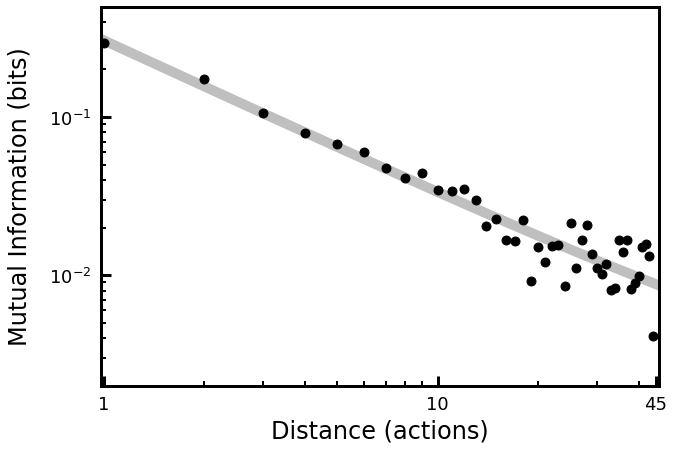

In [66]:
yoff=-.125
ncols = 4
zoom = 10
hr = [0.75, 0.5, 0.5, 0.5]
nrows = np.ceil(len(MI_DF)/ncols).astype(int)
fig = plt.figure(figsize=(len(MI_DF)*zoom,np.sum(hr)*zoom)) 
gs = gridspec.GridSpec(ncols=len(MI_DF), nrows=4, height_ratios=hr) 

row = MI_DF.iloc[0]
axi =0

color = 'k'#LCOL_DICT[row.language]
ax0 = plt.subplot(gs[0,axi])
ax = ax0
sig = np.array(row.MI-row.shuff_MI)
distances = row.distances
sig = sig
# get signal limits
sig_lims = np.log([np.min(sig[sig>0]), np.nanmax(sig)])
sig_lims = [sig_lims[0] - (sig_lims[1]-sig_lims[0])/10,
                sig_lims[1] + (sig_lims[1]-sig_lims[0])/10]

if axi==0: 
        ax.set_ylabel('Mutual Information (bits)', labelpad=5, fontsize=24)
        ax.yaxis.set_label_coords(yoff,0.5)

# model data
#row.concat_results.params.intercept = 0
distances_model = np.logspace(0,np.log10(distances[-1]), base=10, num=1000)
y_model = mf.get_y(mf.powerlaw_decay, row.pow_results, distances)

# plot real data
ax.scatter(distances, sig, alpha = 1, s=80, color=color)   

# plot modelled data
ax.plot(distances, y_model, alpha = 0.25, lw=10, color=color)


ax.set_xlim([distances[0], distances[-1]])
sig_lims[0] = np.log(10e-6)
ax.set_ylim([1e-4, 3])
ax.tick_params(which='both', direction='in', labelsize=14, pad=10)
ax.tick_params(which='major', length=10, width =3)
ax.tick_params(which='minor', length=5, width =2)
ax.set_xscale( "log" , basex=10)
ax.set_yscale( "log" , basey=10)
ax.set_xticks([])
ax.set_xticks([1,10,45])
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
    ax.spines[axis].set_color('k')
ax.set_ylim([2e-3, 0.5])
ax.set_xticks([1,10,45])
ax.set_xticklabels(['1','10','45'], fontsize=16)

if axi !=0:
    for ax in [ax0,ax1,ax2]:
        ax.yaxis.set_ticklabels([])

for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(18) 

for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(18)        

        
gs.update(wspace=0.075, hspace=0.1)
ax.set_xlabel('Distance (actions)', labelpad=5, fontsize=24)

ax.set_xlim([0.98, 46])

save_fig(FIGURE_DIR/'epic_kitchens_mi')